# `EmissionAbsorptionFFModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `EmissionAbsorptionFFModel` model. `EmissionAbsorptionFFModel` models both 21cm emission and absorption observations allowing for a "filling factor" term to account for beam dilution effects in the emission spectra.

In [1]:
# General imports
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

print("pymc version:", pm.__version__)

import bayes_spec

print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi

print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0
caribou_hi version: 1.2.0b0+0.gadf3c86.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionAbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"emission"` and `"absorption"`.

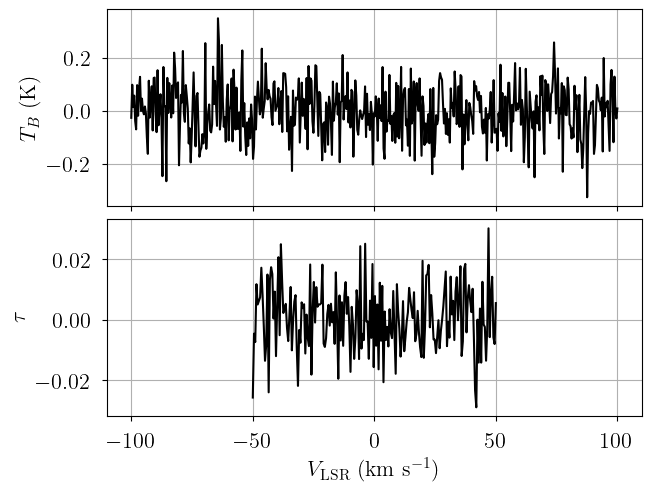

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-100.0, 100.0, 500)  # km s-1
absorption_axis = np.linspace(-50.0, 50.0, 200)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1  # K
rms_absorption = 0.01  # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$",
    ),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
axes[1].plot(
    dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-"
)
axes[1].set_xlabel(dummy_data["emission"].xlabel)
axes[0].set_ylabel(dummy_data["emission"].ylabel)
_ = axes[1].set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import EmissionAbsorptionFFModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = EmissionAbsorptionFFModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_tkin=[3.0, 1.0],  # log10(kinetic temp) prior mean and width (K)
    prior_velocity=[0.0, 20.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.01,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([20.0, 21.0, 20.5]),
    "log10_depth": np.array([0.5, 2.5, 1.0]),
    "log10_tkin": np.array([2.5, 4.0, 3.5]),
    "velocity": np.array([0.0, -5.0, 5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.1,
    "larson_power": 0.3,
}

sim_params_emission = sim_params.copy()
sim_params_emission["filling_factor"] = np.array([0.2, 1.0, 0.5])
sim_params_emission["rms_emission"] = rms_emission
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["rms_absorption"] = rms_absorption
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$",
    ),
}

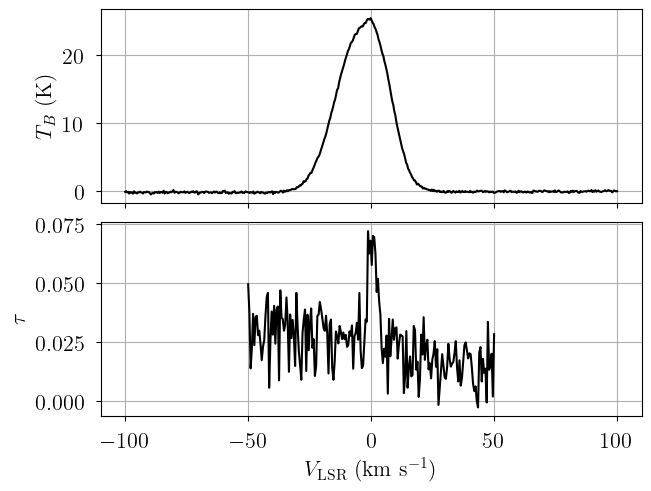

In [5]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [39]:
# Initialize and define the model
model = EmissionAbsorptionFFModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[0.0, 0.5],  # log10(depth) prior mean and width (pc)
    prior_log10_tkin=[3.0, 1.0],  # log10(kinetic temp) prior mean and width (K)
    prior_velocity=[0.0, 20.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.01,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

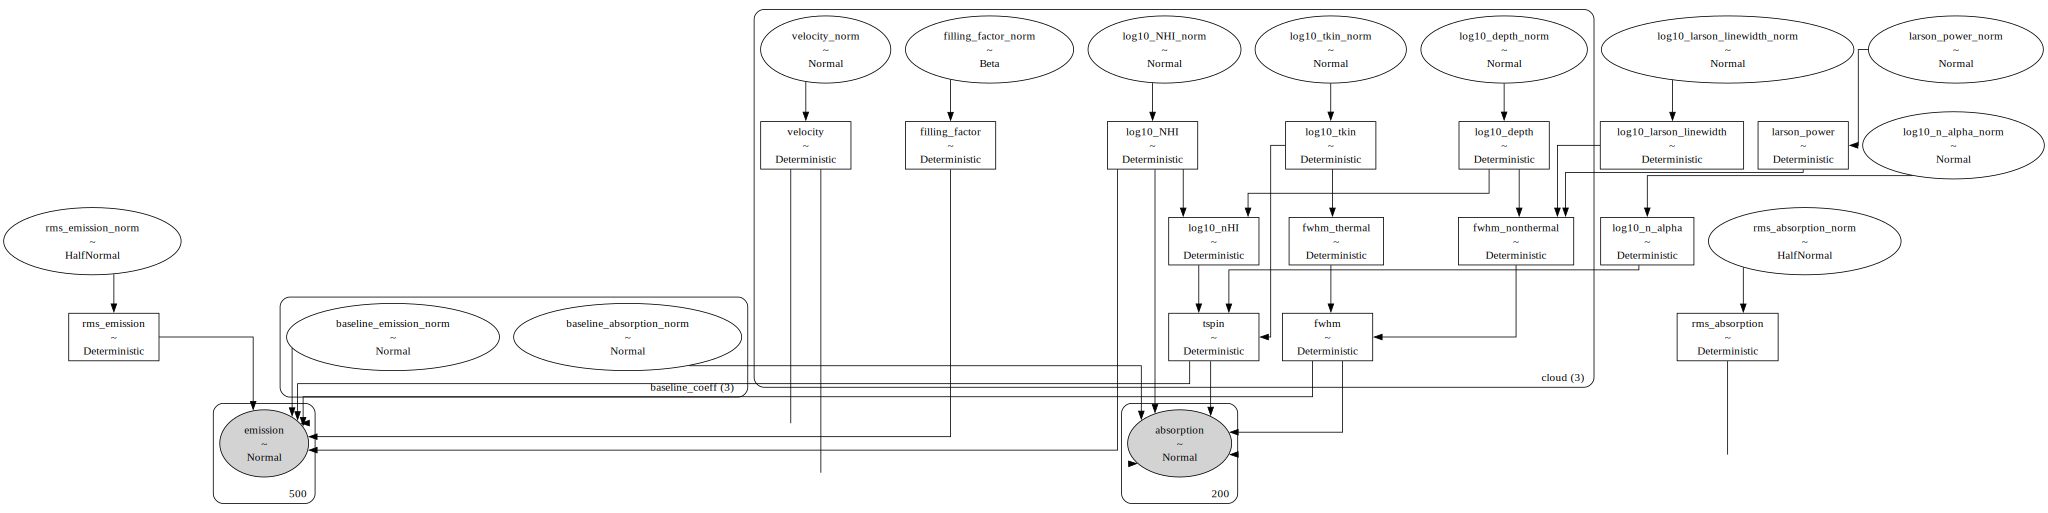

In [40]:
# Plot model graph
model.graph().render("emission_absorption_ff_model", format="png")
model.graph()

In [41]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, <constant>)
   baseline_absorption_norm ~ Normal(0, <constant>)
             log10_NHI_norm ~ Normal(0, 1)
           log10_depth_norm ~ Normal(0, 1)
            log10_tkin_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
        filling_factor_norm ~ Beta(1, 2)
          rms_emission_norm ~ HalfNormal(0, 1)
        rms_absorption_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                log10_depth ~ Deterministic(f(log10_depth_norm))
                 log10_tkin ~ Deterministic(f(log10_tkin_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, baseline_emission_norm, emission, filling_factor_norm, larson_power_norm, log10_NHI_norm, log10_depth_norm, log10_larson_linewidth_norm, log10_n_alpha_norm, log10_tkin_norm, rms_absorption_norm, rms_emission_norm, velocity_norm]


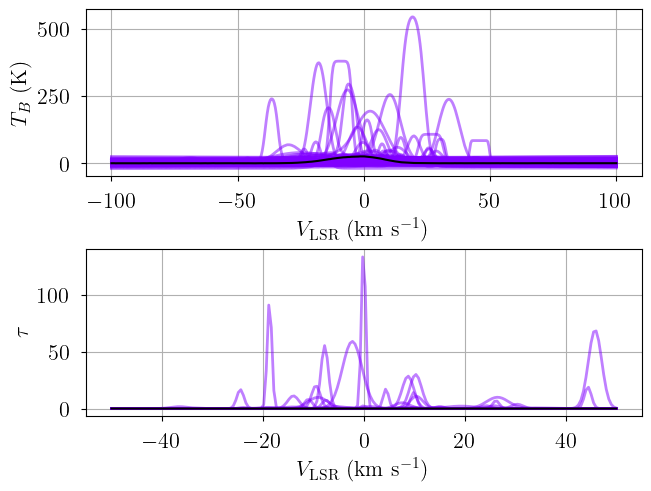

In [42]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

Or we can inspect the prior distributions of the derived quantities to check that they are physically reasonable.

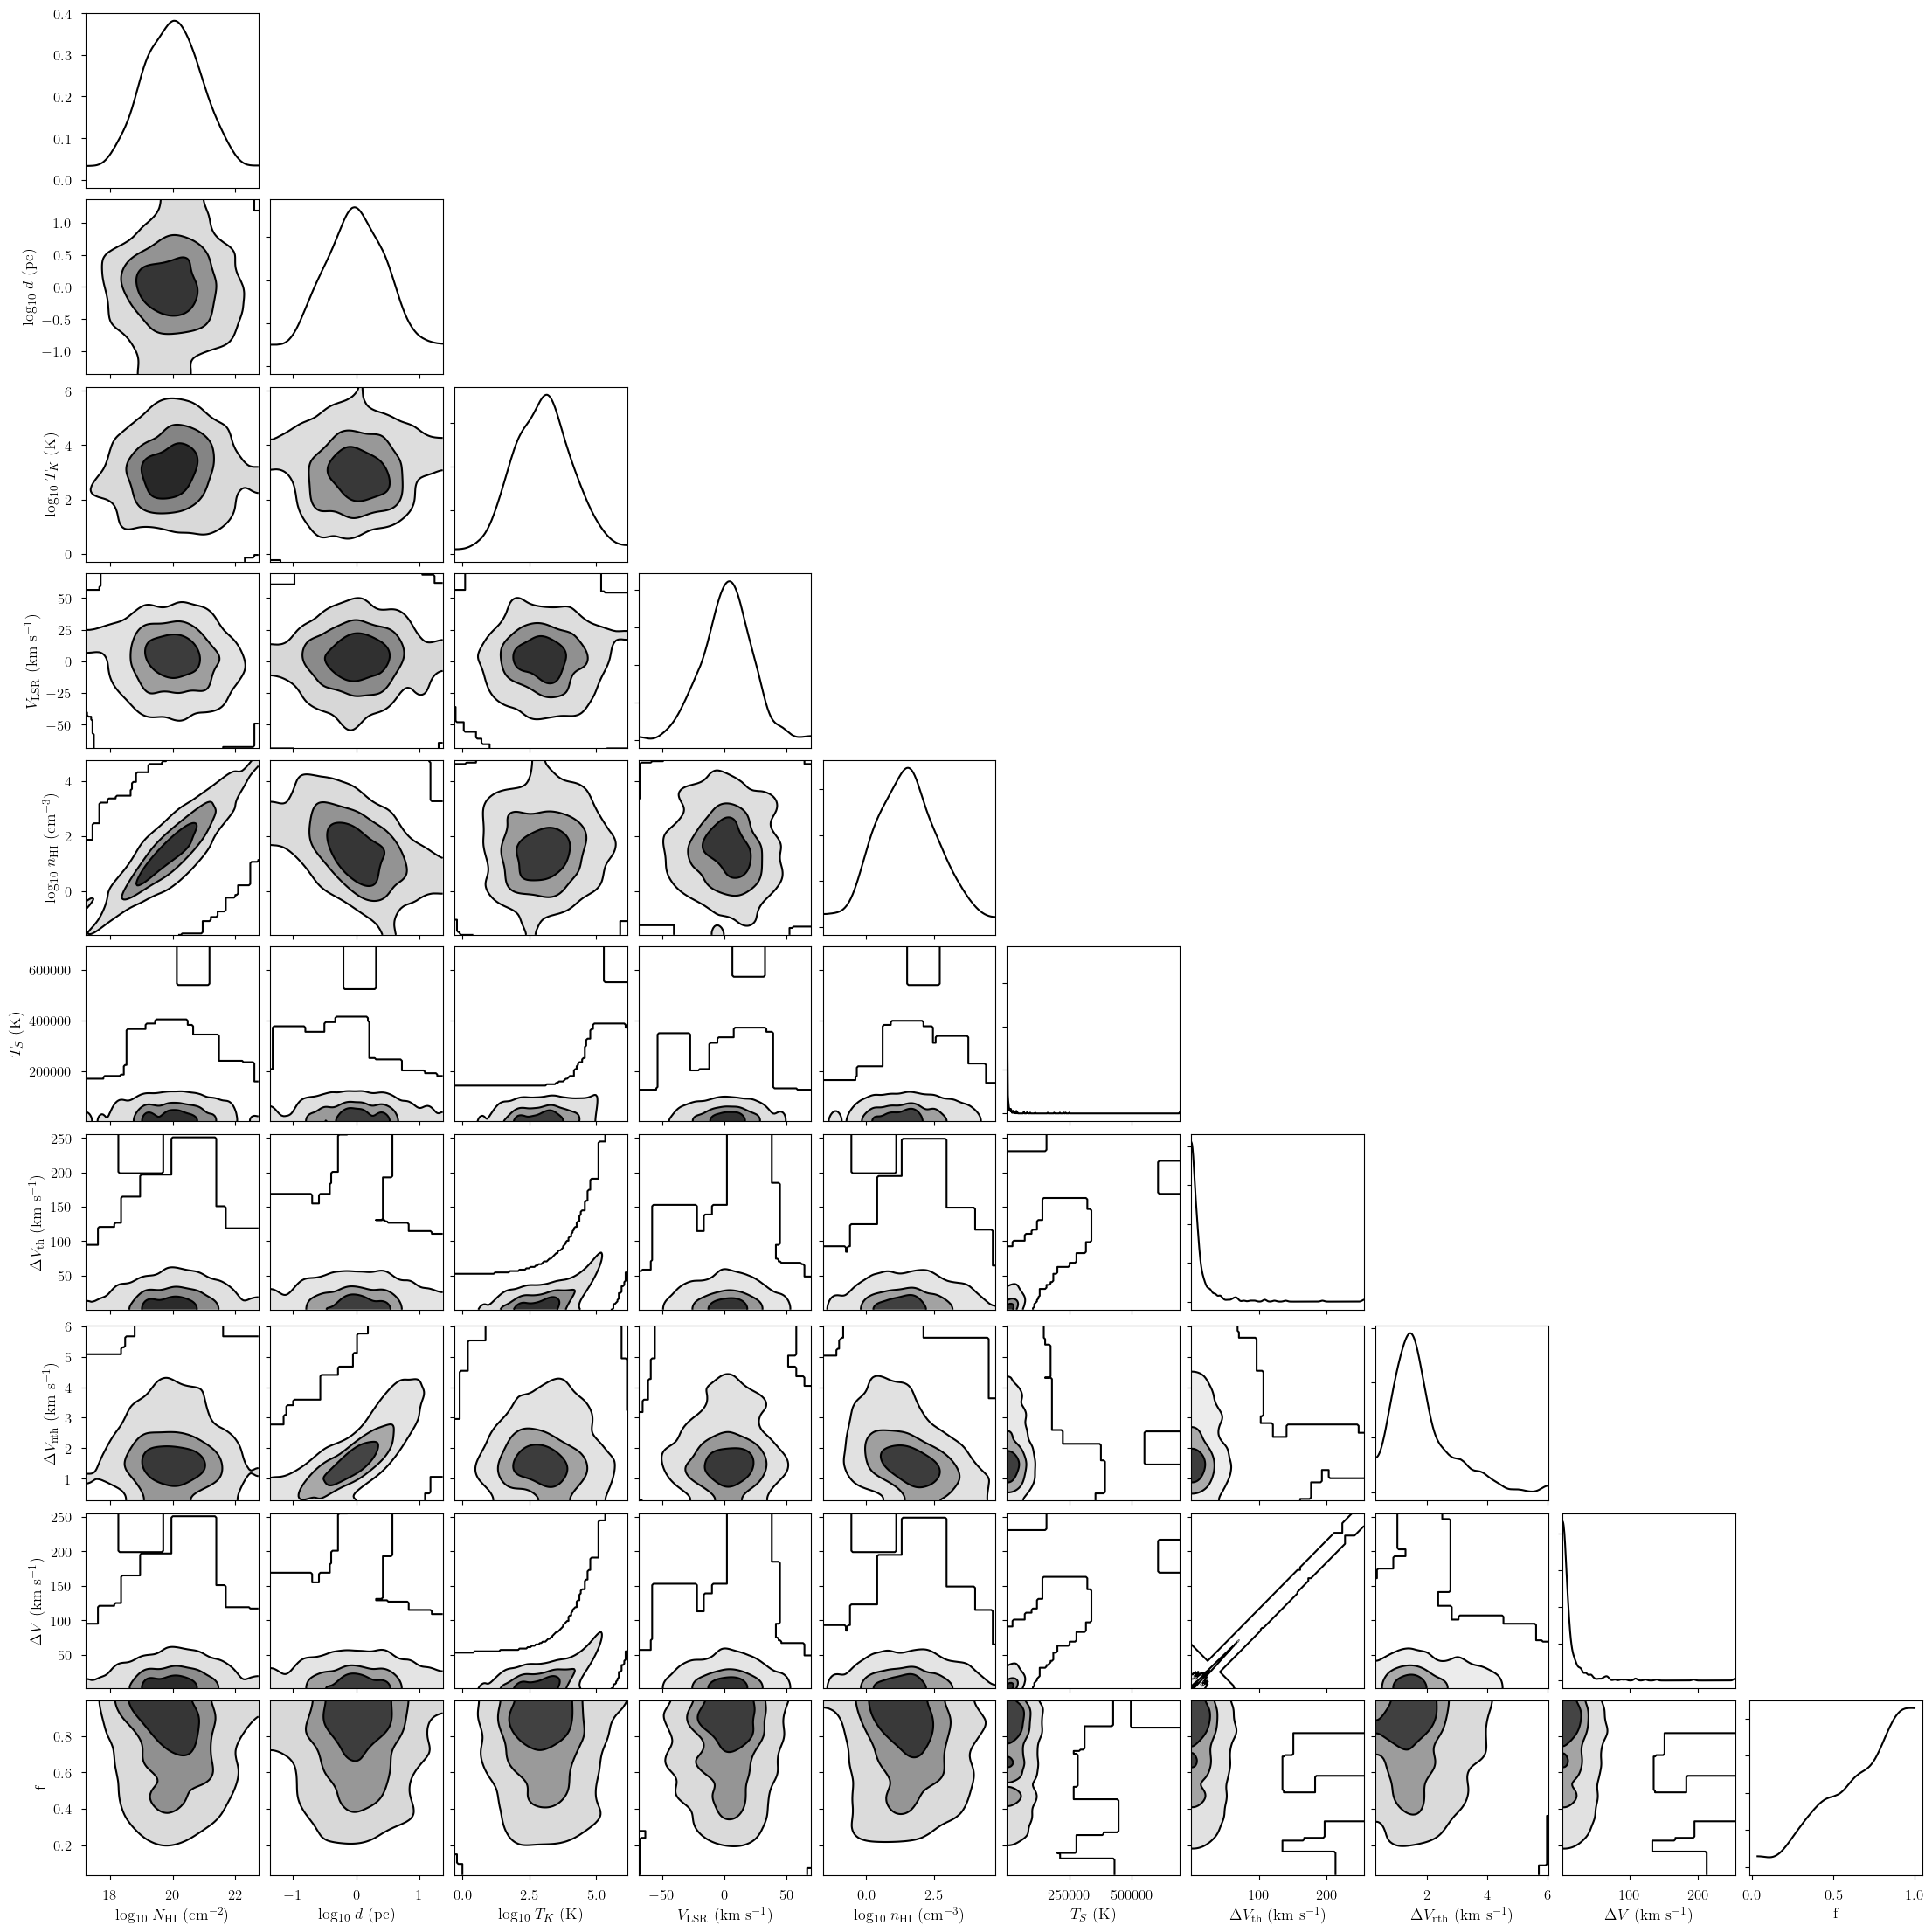

In [43]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior,  # samples
    model.cloud_deterministics,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [44]:
start = time.time()
model.fit(
    n=100_000,  # maximum number of VI iterations
    draws=1_000,  # number of posterior samples
    rel_tolerance=0.01,  # VI relative convergence threshold
    abs_tolerance=0.05,  # VI absolute convergence threshold
    learning_rate=1e-2,  # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 12300
Interrupted at 12,299 [12%]: Average Loss = 1.0593e+05


Output()

Runtime: 0.87 minutes


In [45]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean       sd     hdi_3%    hdi_97%  \
baseline_absorption_norm[0]     -0.030    0.069     -0.175      0.089   
baseline_absorption_norm[1]     -1.407    0.225     -1.798     -0.962   
baseline_absorption_norm[2]     -0.904    0.845     -2.373      0.680   
baseline_emission_norm[0]       -0.460    0.001     -0.462     -0.459   
baseline_emission_norm[1]        0.026    0.003      0.020      0.031   
baseline_emission_norm[2]        0.074    0.020      0.039      0.112   
filling_factor[0]                0.824    0.002      0.820      0.828   
filling_factor[1]                0.863    0.002      0.859      0.867   
filling_factor[2]                0.864    0.002      0.861      0.868   
filling_factor_norm[0]           0.176    0.002      0.172      0.180   
filling_factor_norm[1]           0.137    0.002      0.133      0.141   
filling_factor_norm[2]           0.136    0.002      0.132      0.139   
fwhm[0]                         14.193    0.064     14.081     14.310   
fwhm[1]                         19.657    0.068     19.539     19.767   
fwhm[2]                         24.137    0.082     23.990     24.277   
fwhm_nonthermal[0]               1.225    0.425      0.567      2.032   
fwhm_nonthermal[1]               1.258    0.517      0.466      2.220   
fwhm_nonthermal[2]               1.339    0.615      0.461      2.516   
fwhm_thermal[0]                 14.134    0.046     14.054     14.228   
fwhm_thermal[1]                 19.610    0.048     19.524     19.697   
fwhm_thermal[2]                 24.092    0.063     23.981     24.219   
larson_power                     0.353    0.100      0.165      0.543   
larson_power_norm               -0.468    1.000     -2.355      1.430   
log10_NHI[0]                    20.531    0.001     20.529     20.533   
log10_NHI[1]                    20.705    0.001     20.703     20.707   
log10_NHI[2]                    20.720    0.001     20.718     20.722   
log10_NHI_norm[0]                0.531    0.001      0.529      0.533   
log10_NHI_norm[1]                0.705    0.001      0.703      0.707   
log10_NHI_norm[2]                0.720    0.001      0.718      0.722   
log10_depth[0]                  -0.168    0.347     -0.846      0.459   
log10_depth[1]                  -0.160    0.399     -0.868      0.659   
log10_depth[2]                  -0.104    0.466     -0.967      0.719   
log10_depth_norm[0]             -0.336    0.694     -1.691      0.919   
log10_depth_norm[1]             -0.321    0.798     -1.735      1.319   
log10_depth_norm[2]             -0.208    0.931     -1.934      1.437   
log10_larson_linewidth           0.122    0.070     -0.012      0.251   
log10_larson_linewidth_norm     -0.778    0.703     -2.121      0.514   
log10_nHI[0]                     2.210    0.347      1.584      2.888   
log10_nHI[1]                     2.376    0.399      1.557      3.086   
log10_nHI[2]                     2.335    0.466      1.513      3.197   
log10_n_alpha                   -6.037    1.127     -8.208     -4.106   
log10_n_alpha_norm              -0.037    1.127     -2.208      1.894   
log10_tkin[0]                    3.640    0.003      3.635      3.646   
log10_tkin[1]                    3.925    0.002      3.921      3.928   
log10_tkin[2]                    4.103    0.002      4.099      4.108   
log10_tkin_norm[0]               0.640    0.003      0.635      0.646   
log10_tkin_norm[1]               0.925    0.002      0.921      0.928   
log10_tkin_norm[2]               1.103    0.002      1.099      1.108   
rms_absorption                   0.012    0.001      0.011      0.013   
rms_absorption_norm              1.192    0.066      1.075      1.323   
rms_emission                     0.132    0.005      0.123      0.142   
rms_emission_norm                1.319    0.049      1.230      1.416   
tspin[0]                      4352.958   30.268   4295.628   4410.648   
tspin[1]                      8372.235   53.788   8272.458   8460.869   
tspin[2]           

Sampling: [absorption, emission]


Output()

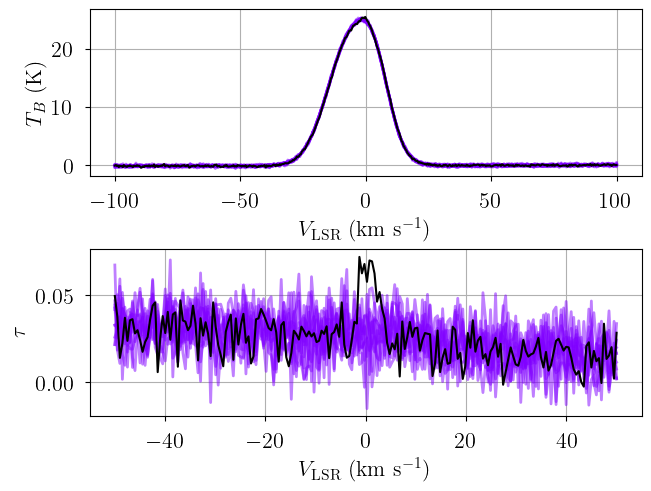

In [46]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

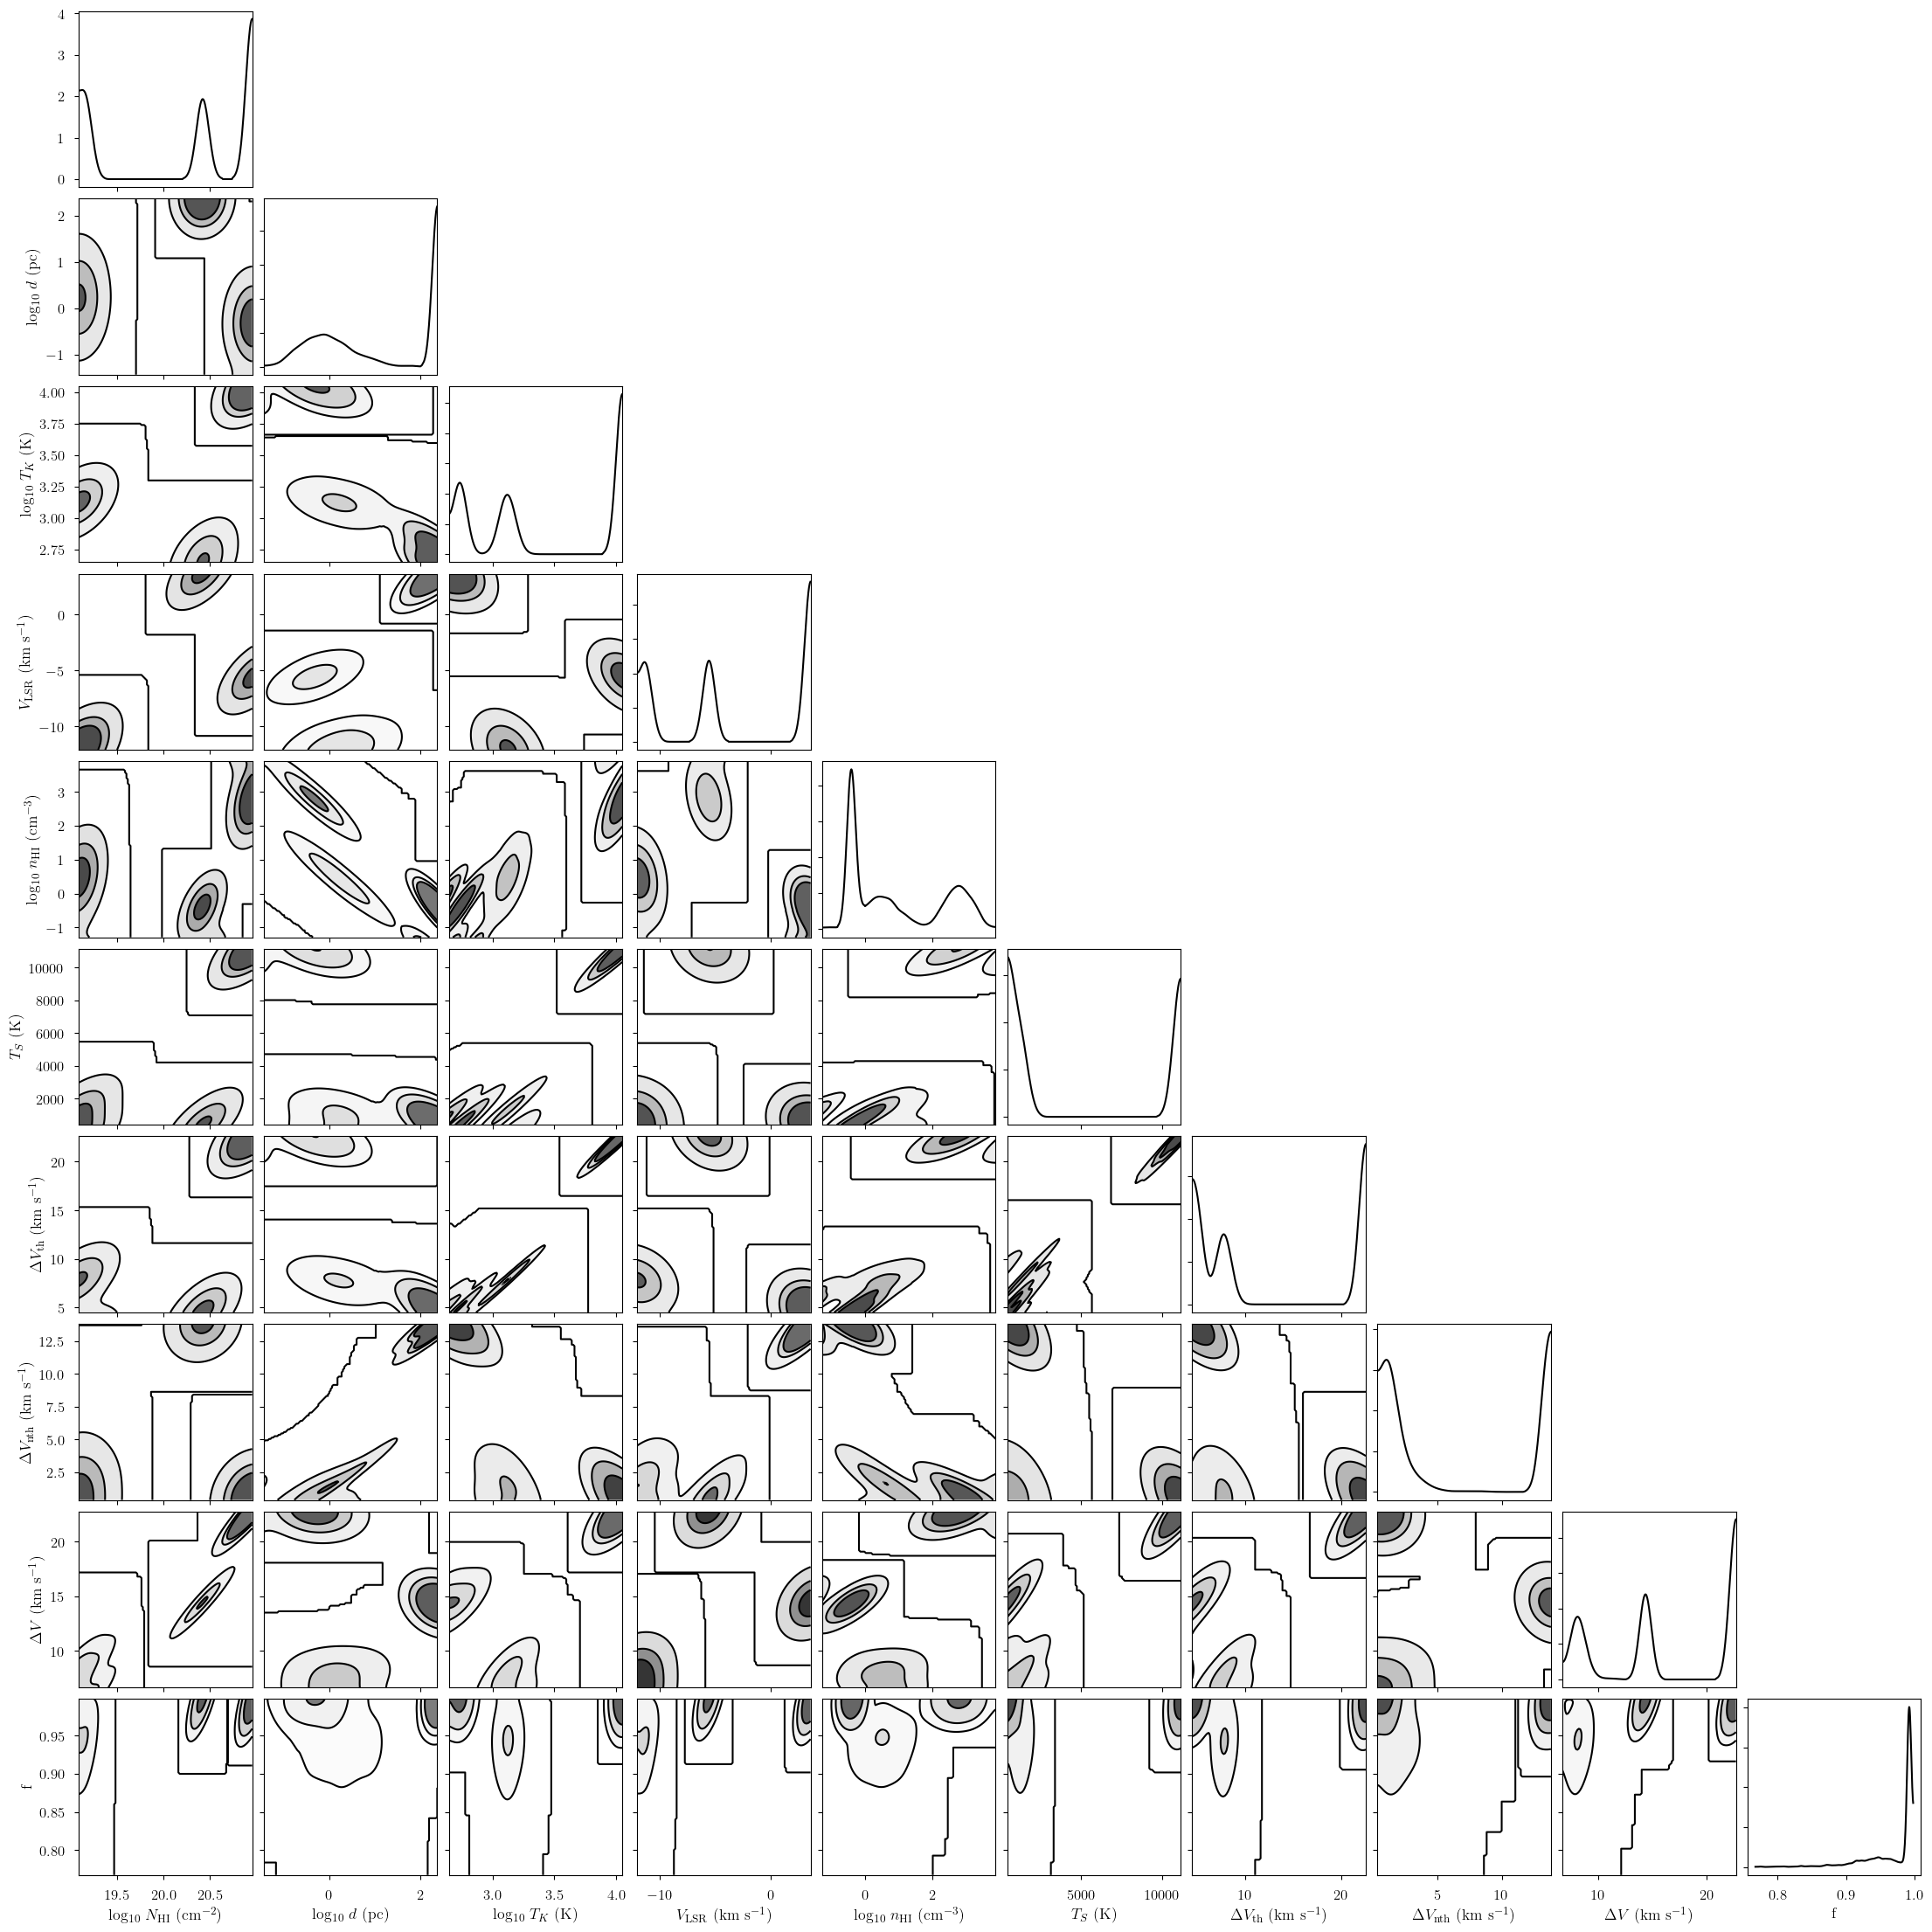

In [28]:
_ = plot_pair(
    model.trace.posterior,  # samples
    model.cloud_deterministics,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [32]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    # init="auto",
    tune=5000,  # tuning samples
    draws=5000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    n_init=1000000,
    init_kwargs={
        "rel_tolerance": 1e-4,
        "abs_tolerance": 1e-4,
        "learning_rate": 1e-4,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.9},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = -842.78
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_tkin_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, filling_factor_norm, rms_emission_norm, rms_absorption_norm]


Output()

Sampling 8 chains for 5_000 tune and 5_000 draw iterations (40_000 + 40_000 draws total) took 16860 seconds.


Adding log-likelihood to trace


Output()

There were 1533 divergences in converged chains.
Runtime: 297.65 minutes


In [33]:
model.solve()

GMM found 2 unique solutions
Solution 0: chains [0, 2, 4, 7]
Solution 1: chains [1, 6]
6 of 8 chains appear converged.


In [35]:
print(model.bic(solution=0))
print(model.bic(solution=1))

-1818.5067281254708
-1818.4727906778037


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [34]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0, 1]


mean        sd    hdi_3%   hdi_97%  \
baseline_absorption_norm[0]    -0.290     0.083    -0.443    -0.133   
baseline_absorption_norm[1]    -1.408     0.198    -1.786    -1.045   
baseline_absorption_norm[2]     0.551     0.913    -1.160     2.252   
baseline_emission_norm[0]      -0.458     0.002    -0.461    -0.455   
baseline_emission_norm[1]       0.026     0.003     0.021     0.031   
baseline_emission_norm[2]       0.032     0.029    -0.019     0.091   
filling_factor[0]               0.613     0.255     0.204     1.000   
filling_factor[1]               0.796     0.155     0.518     1.000   
filling_factor[2]               0.764     0.177     0.438     1.000   
filling_factor_norm[0]          0.387     0.255     0.000     0.796   
filling_factor_norm[1]          0.204     0.155     0.000     0.482   
filling_factor_norm[2]          0.236     0.177     0.000     0.562   
fwhm[0]                        16.552     0.242    16.128    17.014   
fwhm[1]                        19.784     0.472    18.901    20.663   
fwhm[2]                         8.027     0.783     6.559     9.478   
fwhm_nonthermal[0]             12.057     3.802     3.030    15.526   
fwhm_nonthermal[1]              4.404     3.197     0.246    10.740   
fwhm_nonthermal[2]              3.004     1.650     0.358     6.029   
fwhm_thermal[0]                10.259     2.992     6.732    16.393   
fwhm_thermal[1]                18.986     1.255    16.397    20.747   
fwhm_thermal[2]                 7.208     1.156     4.888     9.275   
larson_power                    0.414     0.087     0.250     0.579   
larson_power_norm               0.143     0.868    -1.501     1.788   
log10_NHI[0]                   21.020     0.221    20.723    21.448   
log10_NHI[1]                   20.867     0.108    20.692    21.074   
log10_NHI[2]                   19.434     0.173    19.131    19.780   
log10_NHI_norm[0]               1.020     0.221     0.723     1.448   
log10_NHI_norm[1]               0.867     0.108     0.692     1.074   
log10_NHI_norm[2]              -0.566     0.173    -0.869    -0.220   
log10_depth[0]                  2.035     0.694     0.565     3.294   
log10_depth[1]                  0.757     0.832    -0.816     2.216   
log10_depth[2]                  0.469     0.704    -0.851     1.752   
log10_depth_norm[0]             1.035     0.694    -0.435     2.294   
log10_depth_norm[1]            -0.243     0.832    -1.816     1.216   
log10_depth_norm[2]            -0.531     0.704    -1.851     0.752   
log10_larson_linewidth          0.213     0.097     0.028     0.393   
log10_larson_linewidth_norm     0.128     0.969    -1.720     1.928   
log10_nHI[0]                    0.496     0.841    -0.950     2.319   
log10_nHI[1]                    1.621     0.846     0.108     3.178   
log10_nHI[2]                    0.476     0.729    -0.838     1.847   
log10_n_alpha                  -6.000     0.997    -7.854    -4.083   
log10_n_alpha_norm              0.000     0.997    -1.854     1.917   
log10_tkin[0]                   3.328     0.239     3.014     3.779   
log10_tkin[1]                   3.894     0.062     3.771     3.975   
log10_tkin[2]                   3.043     0.150     2.747     3.295   
log10_tkin_norm[0]              0.328     0.239     0.014     0.779   
log10_tkin_norm[1]              0.894     0.062     0.771     0.975   
log10_tkin_norm[2]              0.043     0.150    -0.253     0.295   
rms_absorption                  0.011     0.001     0.010     0.012   
rms_absorption_norm             1.109     0.056     1.001     1.213   
rms_emission                    0.114     0.004     0.107     0.121   
rms_emission_norm               1.139     0.036     1.071     1.206   
tspin[0]                     2344.765  1491.948   860.769  5724.619   
tspin[1]                     7670.487  1161.289  5215.787  9390.219   
tspin[2]                     1132.921   353.211   437.432  1760.294   
velocity[0]                     2.226     0.310     1.625

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption, emission]


Output()

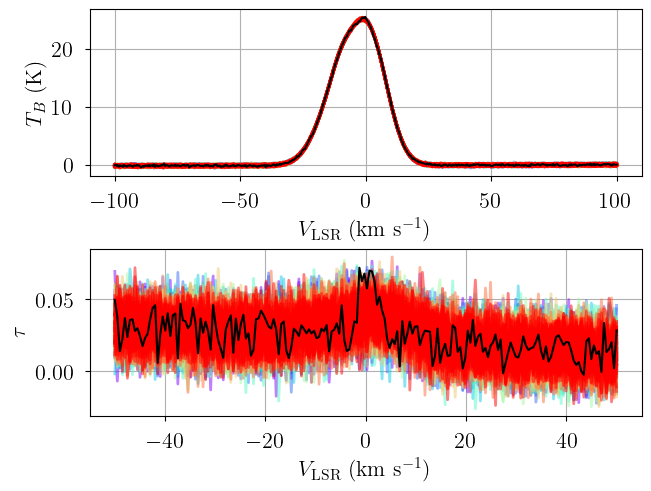

In [36]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

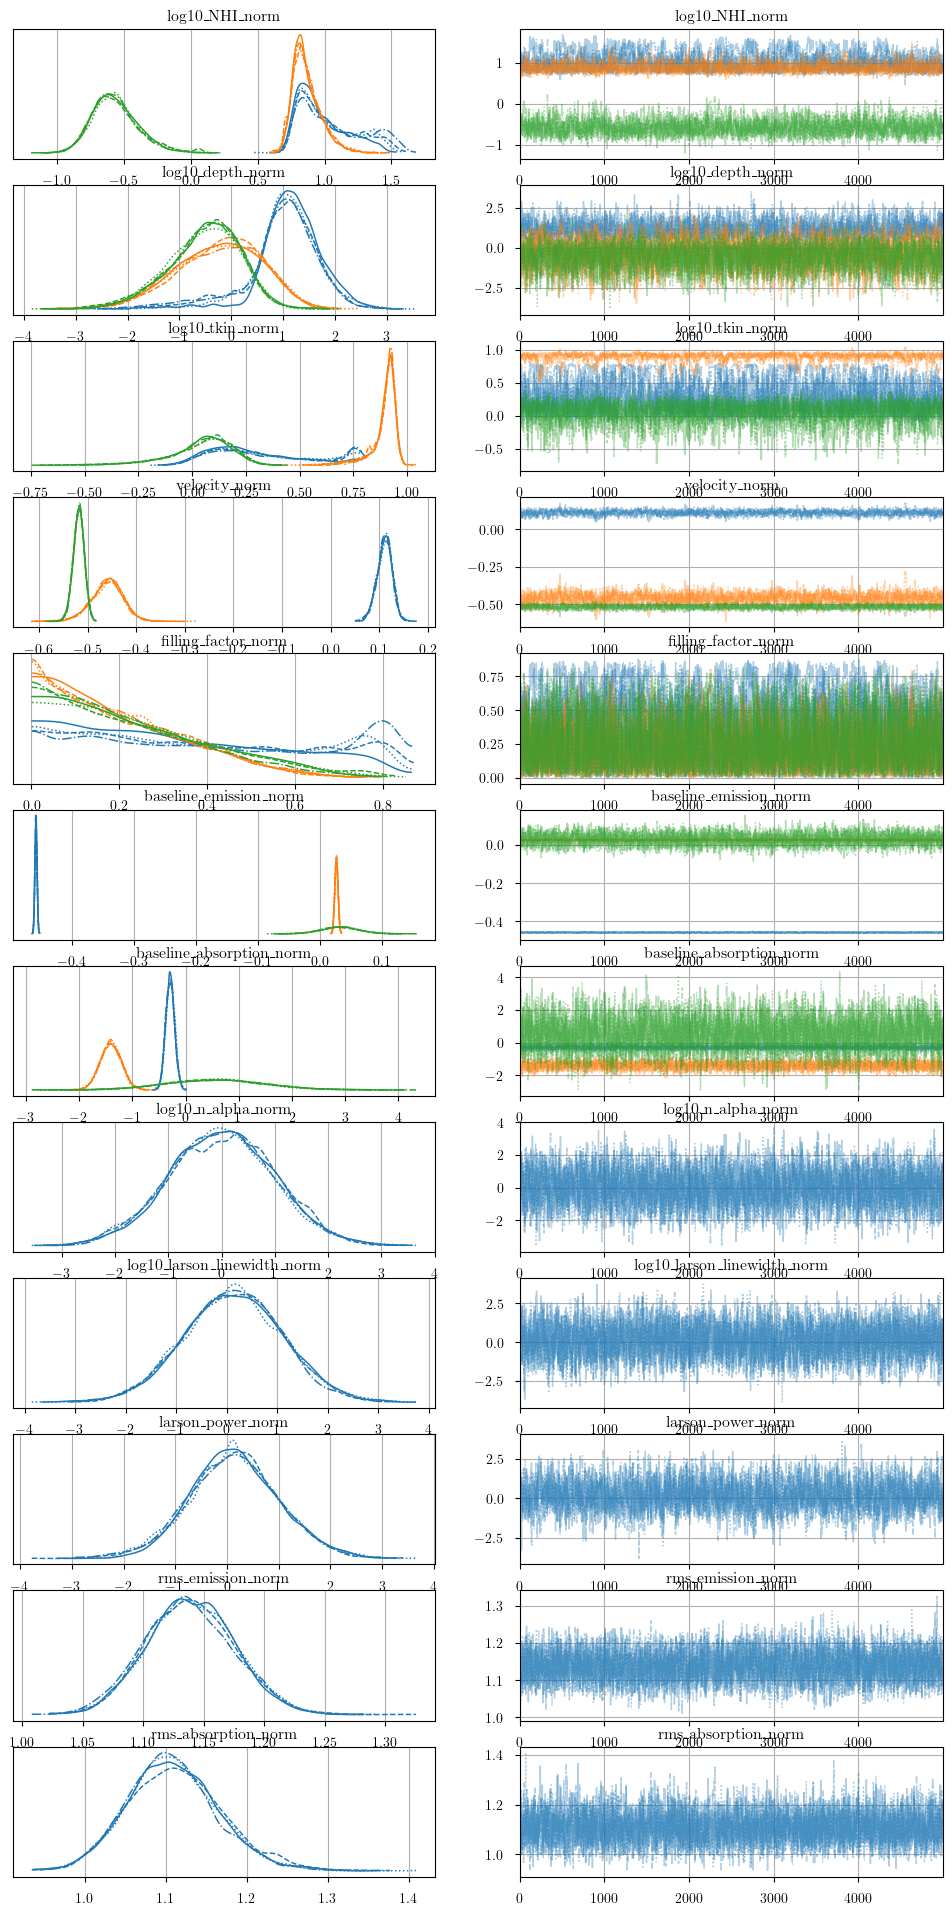

In [38]:
from bayes_spec.plots import plot_traces

_ = plot_traces(
    model.trace.solution_0,
    model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs,
)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

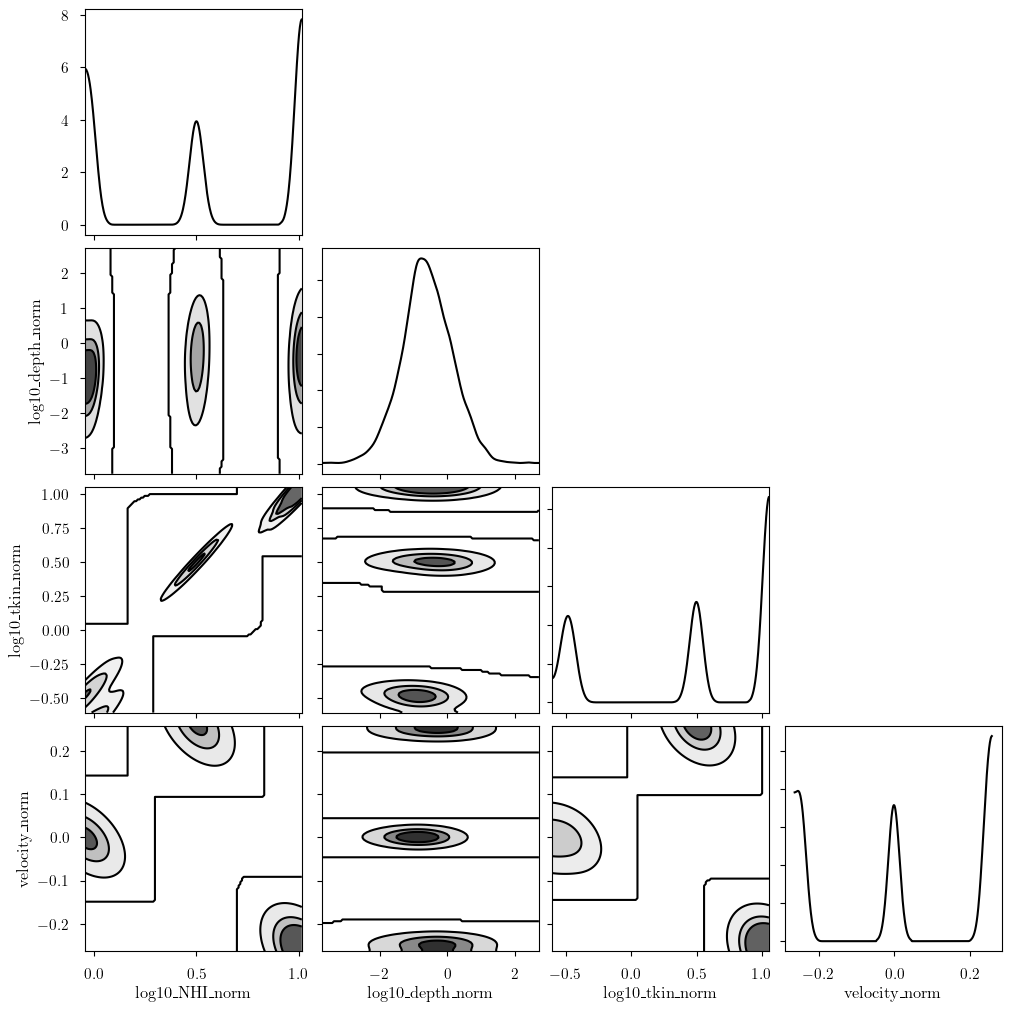

In [21]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

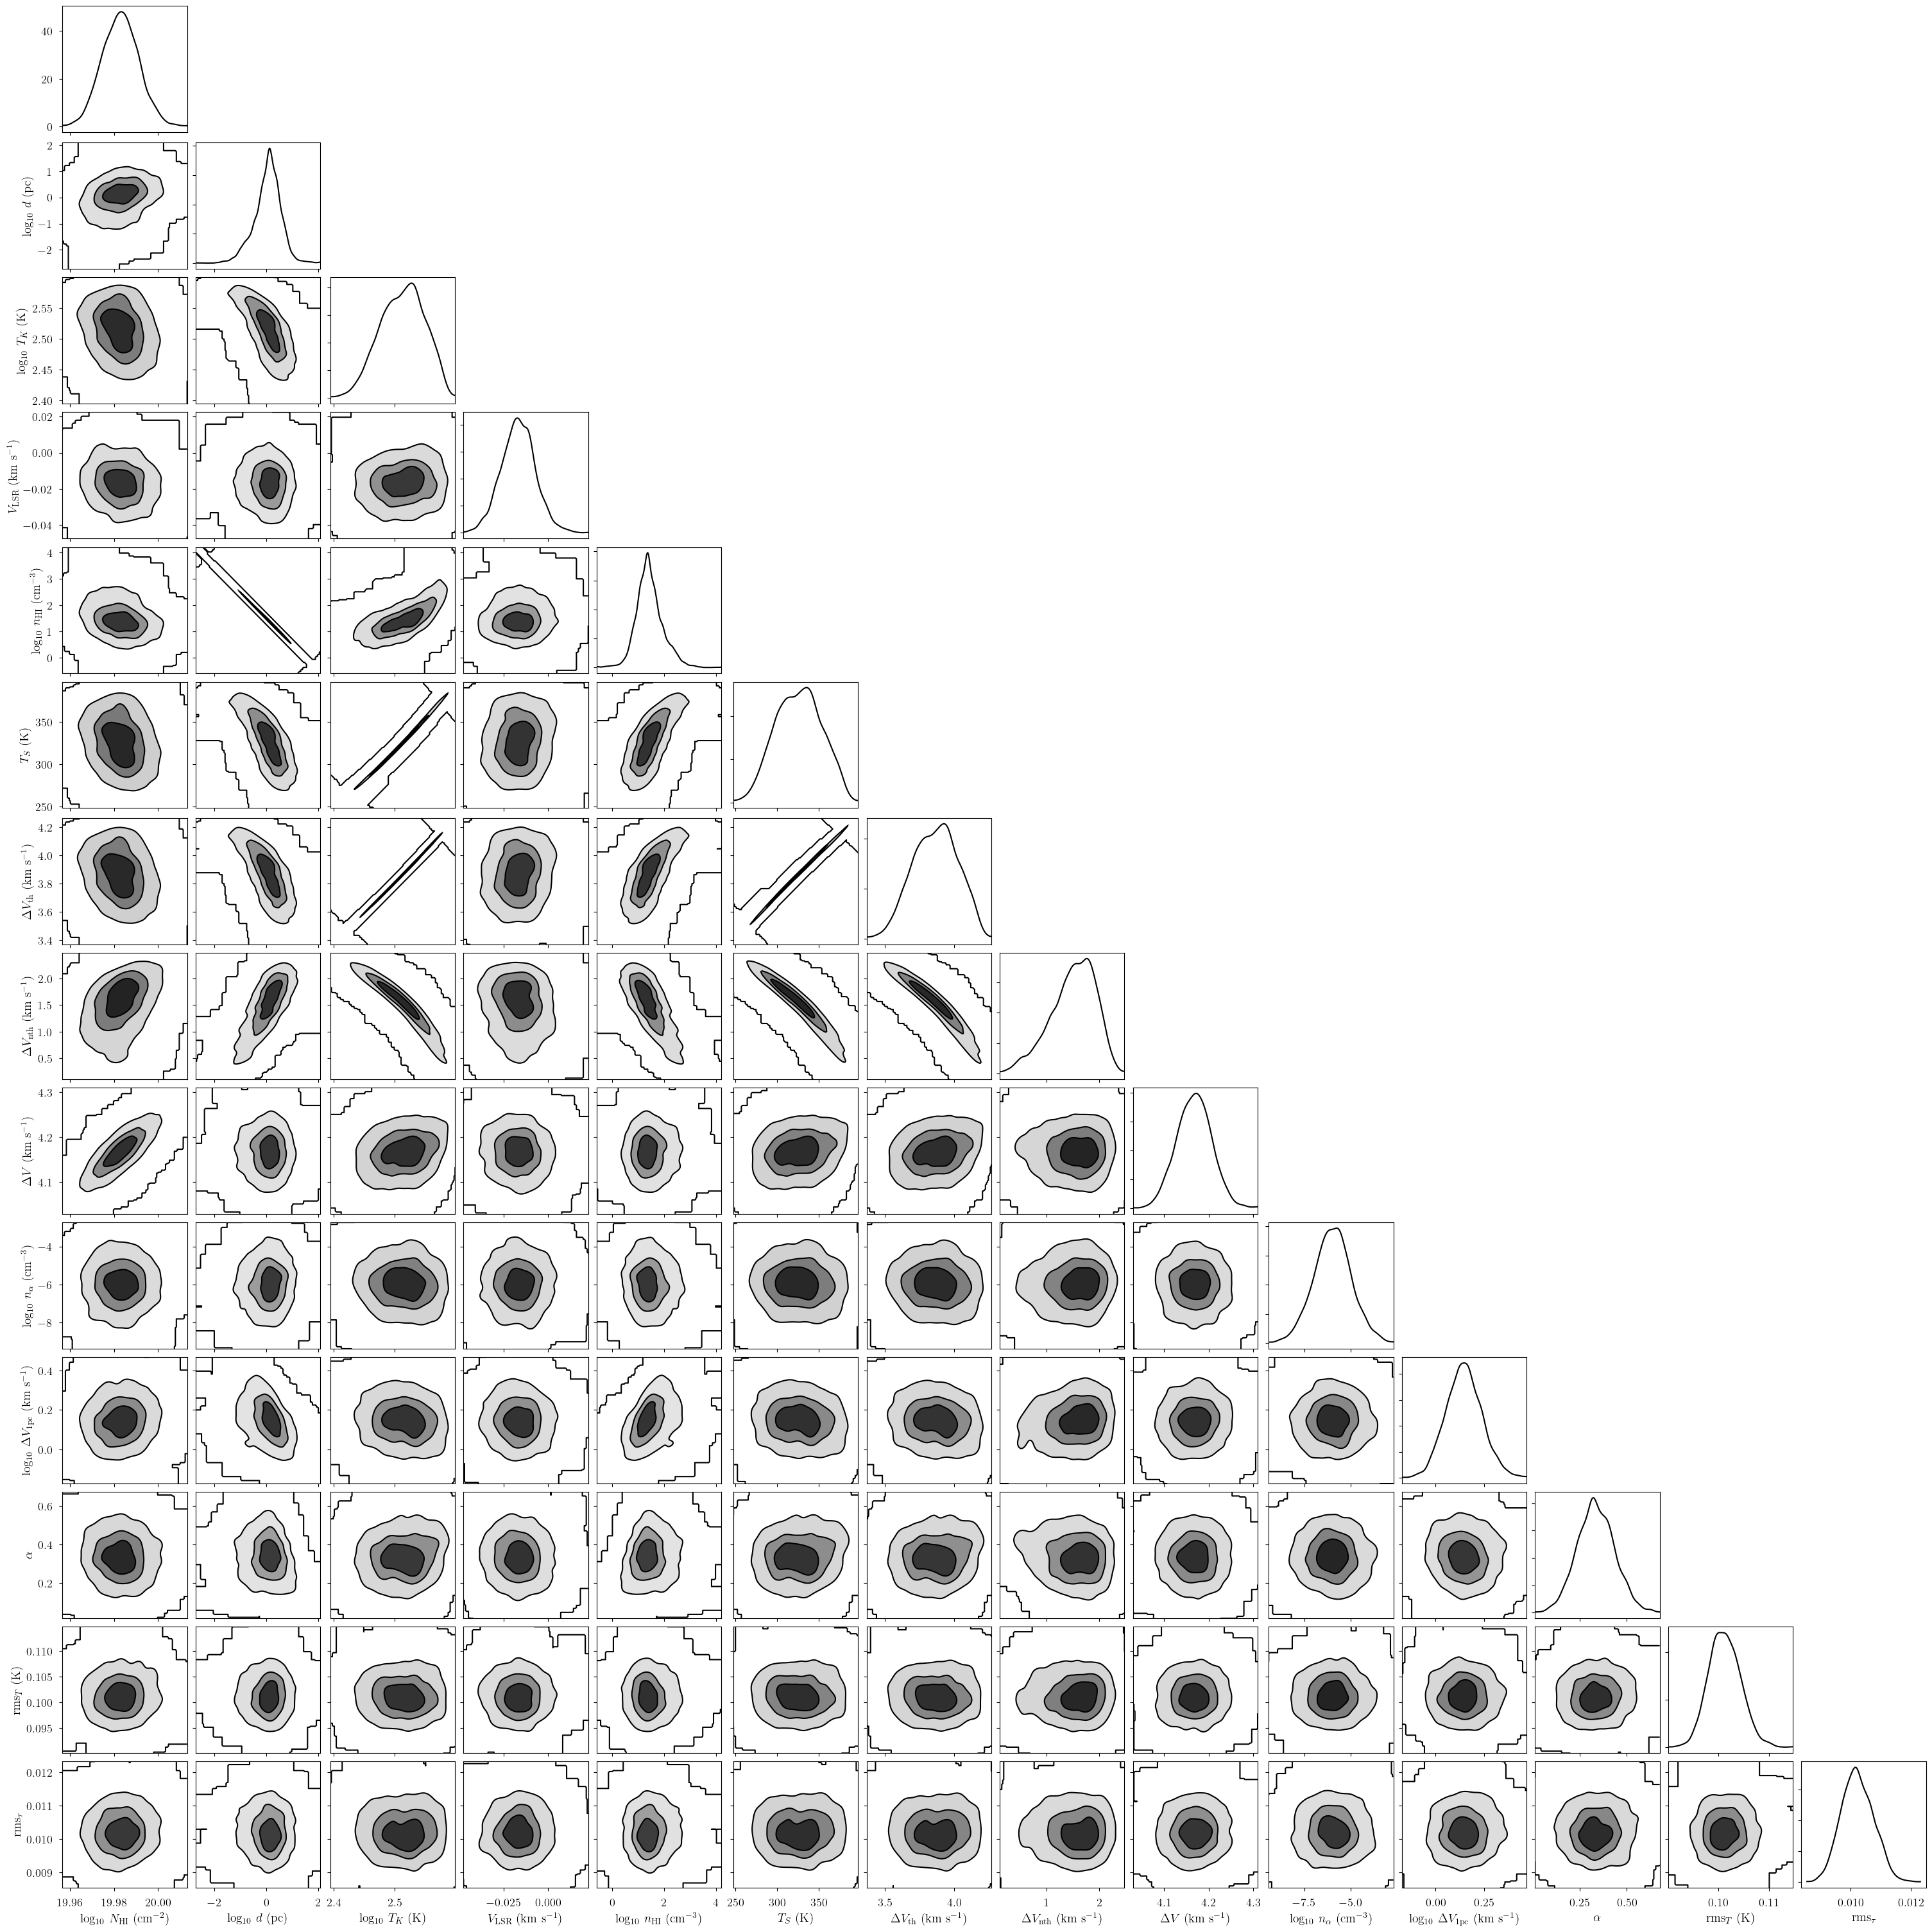

In [22]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1),  # samples
    model.cloud_deterministics + model.hyper_deterministics,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [23]:
point_stats = az.summary(model.trace.solution_0, kind="stats", hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -1987.2937825611048


mean       sd    hdi_16%    hdi_84%
baseline_absorption_norm[0]     -0.202    0.065     -0.264     -0.138
baseline_absorption_norm[1]     -1.112    0.178     -1.302     -0.952
baseline_absorption_norm[2]     -0.027    0.837     -0.810      0.827
baseline_emission_norm[0]       -0.444    0.001     -0.445     -0.443
baseline_emission_norm[1]        0.025    0.002      0.023      0.027
baseline_emission_norm[2]        0.061    0.021      0.040      0.080
fwhm[0]                         12.256    0.143     12.104     12.386
fwhm[1]                          4.167    0.039      4.129      4.205
fwhm[2]                         22.529    0.088     22.449     22.622
fwhm_nonthermal[0]               2.345    1.115      0.796      3.162
fwhm_nonthermal[1]               1.498    0.421      1.232      2.040
fwhm_nonthermal[2]               2.473    1.269      0.796      3.282
fwhm_thermal[0]                 11.975    0.286     11.799     12.329
fwhm_thermal[1]                  3.863    0.159      3.680      4.014
fwhm_thermal[2]                 22.356    0.184     22.263     22.579
larson_power                     0.337    0.098      0.237      0.428
larson_power_norm               -0.634    0.980     -1.633      0.284
log10_NHI[0]                    20.500    0.014     20.486     20.513
log10_NHI[1]                    19.983    0.008     19.975     19.991
log10_NHI[2]                    21.000    0.004     20.996     21.004
log10_NHI_norm[0]                0.500    0.014      0.486      0.513
log10_NHI_norm[1]               -0.017    0.008     -0.025     -0.009
log10_NHI_norm[2]                1.000    0.004      0.996      1.004
log10_depth[0]                   0.556    0.773     -0.123      1.369
log10_depth[1]                   0.044    0.523     -0.277      0.643
log10_depth[2]                   0.588    0.801     -0.052      1.464
log10_depth_norm[0]             -0.444    0.773     -1.123      0.369
log10_depth_norm[1]             -0.956    0.523     -1.277     -0.357
log10_depth_norm[2]             -0.412    0.801     -1.052      0.464
log10_larson_linewidth           0.147    0.091      0.056      0.235
log10_larson_linewidth_norm     -0.534    0.915     -1.438      0.351
log10_nHI[0]                     1.454    0.773      0.627      2.118
log10_nHI[1]                     1.449    0.521      0.849      1.764
log10_nHI[2]                     1.923    0.801      1.032      2.548
log10_n_alpha                   -5.986    1.005     -6.916     -4.993
log10_n_alpha_norm               0.014    1.005     -0.916      1.007
log10_tkin[0]                    3.496    0.021      3.484      3.522
log10_tkin[1]                    2.513    0.036      2.480      2.555
log10_tkin[2]                    4.038    0.007      4.035      4.047
log10_tkin_norm[0]               0.496    0.021      0.484      0.522
log10_tkin_norm[1]              -0.487    0.036     -0.520     -0.445
log10_tkin_norm[2]               1.038    0.007      1.035      1.047
rms_absorption                   0.010    0.001      0.010      0.011
rms_absorption_norm              1.022    0.053      0.967      1.073
rms_emission                     0.101    0.003      0.098      0.105
rms_emission_norm                1.013    0.032      0.984      1.046
tspin[0]                      3076.265  205.838   2966.297   3321.560
tspin[1]                       326.105   26.950    296.173    352.875
tspin[2]                     10649.438  602.921  10611.981  11168.670
velocity[0]                      4.963    0.056      4.908      5.020
velocity[1]                     -0.017    0.010     -0.027     -0.008
velocity[2]                     -4.965    0.090     -5.064     -4.885
velocity_norm[0]                 0.248    0.003      0.245      0.251
velocity_norm[1]                -0.001    0.000     -0.001     -0.000
velocity_norm[2]                -0.248    0.004     -0.253     -0.244